In [6]:
import numpy as np
from scipy.signal import butter, filtfilt, welch, savgol_filter
from scipy.fft import fft
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from utils.visualize import *
from utils.signal_process import *
import os

from pyampd import ampd
from glob import glob
from sklearn.decomposition import PCA
from dataclasses import dataclass
from typing import Tuple, Optional

# Test file

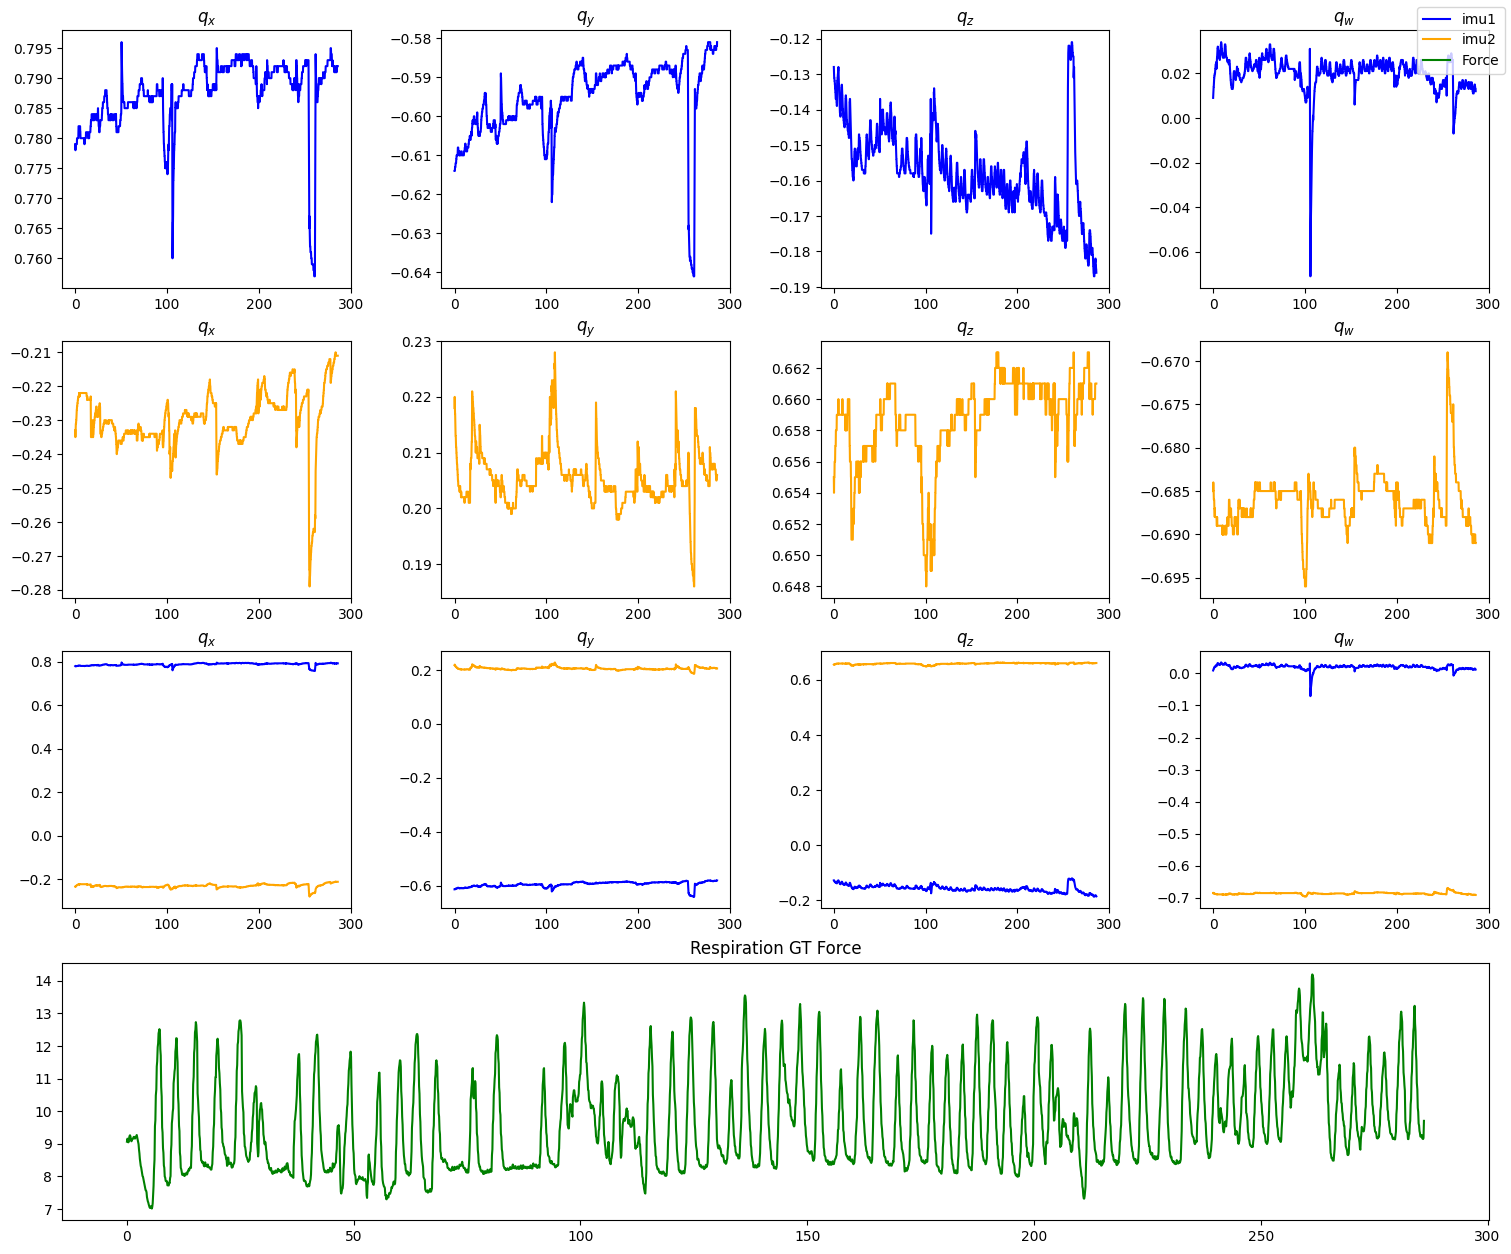

In [7]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

# action_name = "stand_3" # sit_1, stand_1, walk_stand_1, run_stand_1
# file_path = f"./data/2P/train/{action_name}.csv"

action_name = "stand_0407_0808" # sit_0407_0746, sit_0407_0751, stand_0407_0808, walk_stand_0407_0852
file_path = f"./data/2P/test/{action_name}.csv"

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)

# Paper 4

In [8]:
@dataclass
class Result:
    abdomen_estimate: np.ndarray
    abdomen_signal: np.ndarray
    abdomen_pmaxima: np.ndarray
    abdomen_pminima: np.ndarray
    abdomen_rr_whole: np.ndarray
    abdomen_fpeak: float
    timestamp: np.ndarray


class RespAnalyzer:
    def __init__(
        self, win_len=51, polyord=2, bpass=2, max_val=0.48, fs=10, thresh_const=0.04
    ):
        self.win_len = win_len
        self.polyord = polyord
        self.bpass = bpass
        self.max_val = max_val
        self.fs = fs
        self.thresh_const = thresh_const

    @staticmethod
    def quaternion_product(q: np.ndarray, r: np.ndarray) -> np.ndarray:
        a1, b1, c1, d1 = q
        a2, b2, c2, d2 = r

        w = a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2
        x = a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2
        y = a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2
        z = a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2

        return np.array([w, x, y, z])

    def baseline_avg(self, q: np.ndarray, win_size: int = 97) -> np.ndarray:
        baseline_quats = np.zeros_like(q)

        for i in range(q.shape[1]):
            avg = np.convolve(q[:, i], np.ones(win_size) / win_size, mode="same")
            baseline_quats[:, i] = q[:, i] - avg

        return baseline_quats

    def get_thresh(self, q: np.ndarray) -> Tuple[np.ndarray, float]:
        pca = PCA(n_components=1)  # get the first component with maximum variance
        pca_signal = pca.fit_transform(q)[:, 0]  # primary component

        filtered_signal = savgol_filter(
            pca_signal, window_length=self.win_len, polyorder=self.polyord
        )
        peaks = ampd.find_peaks(filtered_signal)
        if len(peaks) > 1:
            peak_distances = np.diff(peaks)
            inverse_distances = 1 / peak_distances  # distances to frequency

            fmean = np.mean(inverse_distances)
            fstd = np.std(inverse_distances)
        else:
            print("Warn: no peaks here")
            fmean, fstd = 0.0, 0.0

        fLow = fmean - fstd if fmean > 0 else 0

        return filtered_signal, fLow

    def psd_max(
        self, data: np.ndarray, min_val: float, max_val: float
    ) -> Optional[float]:
        freq, psd = welch(data, fs=self.fs, window="hamming", noverlap=50, nperseg=300)

        valid_freq = np.where((freq >= min_val) & (freq <= max_val))[0]
        if not valid_freq.size:
            return None

        fpeak_idx = valid_freq[np.argmax(psd[valid_freq])]
        fpeak = freq[fpeak_idx]  # get the peak freq

        return fpeak

    def signal_max_min(
        self, signal: np.ndarray, fpeak: float
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        
        f_U = fpeak + self.thresh_const
        f_L = max(0.05, fpeak - self.thresh_const)

        b, a = butter(self.bpass, [f_L, f_U], btype="band")
        bandpass_filtered = filtfilt(b, a, signal)

        savgoled = savgol_filter(
            bandpass_filtered, window_length=self.win_len, polyorder=self.polyord
        )

        maxima = ampd.find_peaks(savgoled)
        minima = ampd.find_peaks(-savgoled)

        return savgoled, maxima, minima

    def metrics(
        self, min_indices: int, max_indices: np.ndarray, file_len: int
    ) -> Tuple[np.ndarray, np.ndarray]:
        resp_rates = []
        rr_whole = []

        for i in range(len(min_indices) - 1):
            cycle_maxima = max_indices[
                (max_indices > min_indices[i]) & (max_indices < min_indices[i + 1])
            ]

            if len(cycle_maxima) == 1:  # Valid breath cycle with one peak
                max_idx = cycle_maxima[0]

                inhale_time = (max_idx - min_indices[i]) / self.fs
                exhale_time = (min_indices[i + 1] - max_idx) / self.fs
                total_time = inhale_time + exhale_time
                resp_rate = 60 / total_time  # breaths per minute

                resp_rates.append(resp_rate)
                
            delta_t = (min_indices[i + 1] - min_indices[i]) / self.fs
            rr_pred = 60 / delta_t
            rr_range = min_indices[i + 1] - min_indices[i]
            
            # rr_whole is empty
            if not rr_whole:
                rr_whole.extend([rr_pred] * min_indices[i])
                rr_whole.extend([rr_pred] * rr_range)
            else:
                rr_whole.extend([rr_pred] * rr_range)

        if len(rr_whole) < file_len:
            rr_whole.extend([rr_pred] * (file_len-len(rr_whole)))

        return np.array(resp_rates), np.array(rr_whole)
        
    def visualize(
        self,
        idx: np.ndarray,
        signal: np.ndarray,
        min_indices: np.ndarray,
        max_indices: np.ndarray,
        gt_force: np.ndarray,
        title: str = "Breathing Cycles",
    ) -> plt.Figure:

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

        ax1.plot(idx, signal, "b-", label="Filtered Signal", linewidth=1.5)

        # peaks
        valid_min = min_indices[(min_indices >= 0) & (min_indices < len(signal))]
        ax1.scatter(
            idx[valid_min],
            signal[valid_min],
            color="red",
            marker="x",
            s=100,
            label="Minima",
        )
        valid_max = (
            max_indices[(max_indices >= 0) & (max_indices < len(signal))]
        )
        ax1.scatter(
            idx[valid_max],
            signal[valid_max],
            color="green",
            marker="o",
            s=100,
            label="Maxima",
        )

        ax1.set_xlabel("Timestamp")
        ax1.set_ylabel("Amplitude")
        ax1.legend()
        ax1.set_title(title)
        ax1.grid(True, alpha=0.3)

        ax2.plot(idx, gt_force, "g-", label="Respiration Effort")
        ax2.set_ylabel("Respiration Effort")
        ax2.tick_params(axis="y")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        freq, psd = welch(
            signal, fs=self.fs, window="hamming", noverlap=50, nperseg=300
        )

        ax3.plot(freq, psd, "b-", linewidth=1.5, label="PSD")
        ax3.set_xlabel("Frequency (Hz)")
        ax3.set_ylabel("Power Spectral Density")
        ax3.grid(True, alpha=0.3)

        ax3.legend()
        ax3.set_xlim(0, 1)  # Focus on relevant frequency range

        plt.tight_layout()
        return fig

    def eval(self, data: pd.DataFrame) -> Result:
        q_ab = data[["imu1_q_x", "imu1_q_y", "imu1_q_z", "imu1_q_w"]].to_numpy()
        q_ref = data[["imu2_q_x", "imu2_q_y", "imu2_q_z", "imu2_q_w"]].to_numpy()

        # Get thorax quaternion wrt ref
        # q_ab_ref = quaternion_product(q_ab, q_ref.T)
        q_ab_ref = np.array([quaternion_multiply(q_ab[i], quaternion_inverse(q_ref[i])) for i in range(len(q_ab))])

        # Establish baseline by averaging quaternions
        # base_q_ab = self.baseline_avg(q_ab)
        base_q_ab = self.baseline_avg(q_ab_ref)

        # Find the best component and get a frequency estimate
        ab_filtered_signal, ab_fLow = self.get_thresh(base_q_ab)

        # print(f"ab_fLow:{ab_fLow}")
        # fLow = min(th_fLow, ab_fLow)
        fLow = ab_fLow

        # get the region of interest by removing peaks generated by movement
        ab_fpeak = self.psd_max(ab_filtered_signal, fLow, max_val=self.max_val)

        # Get the crest and trough of the signal
        ab_sig, ab_max, ab_min = self.signal_max_min(ab_filtered_signal, ab_fpeak)

        # Estimate RR
        abdomen_result, abdomen_rr_whole = self.metrics(ab_min, ab_max, len(q_ab))
        # print(f"len(q_ab):{len(q_ab)}")
        # print(f"len(abdomen_rr_whole):{len(abdomen_rr_whole)}")
        # print(abdomen_rr_whole[:100])

        return Result(
            abdomen_estimate=abdomen_result,
            abdomen_signal=ab_sig,
            abdomen_pmaxima=ab_max,
            abdomen_pminima=ab_min,
            abdomen_fpeak=ab_fpeak,
            abdomen_rr_whole=abdomen_rr_whole,
            timestamp=data.index,
        )

# Paper 5

In [9]:
# Quaternion operations
# q: (qx, qy, qz, qw)
def quaternion_inverse(q):
    """Returns the inverse of a quaternion."""
    q_conj = q * np.array([-1, -1, -1, 1])
    return q_conj / np.dot(q, q)

def quaternion_multiply(q1, q2):
    """Multiplies two quaternions."""
    x1, y1, z1, w1 = q1
    x2, y2, z2, w2 = q2
    
    return np.array([
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2,
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
    ])

# qv: (sample_num, 4)
def calculate_theta(qv, qd):
    """Calculate relative angle theta from two quaternions."""
    qr = np.array([quaternion_multiply(qv[i], quaternion_inverse(qd[i])) for i in range(len(qv))])
    wr = qr[:, 3]
    theta = 2 * np.arccos(np.clip(wr, -1.0, 1.0))
    return theta

def bandpass_filter(signal, fs=10, lowcut=0.1, highcut=1.5, order=4):
    """Apply a Butterworth bandpass filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def estimate_rr_gt(theta, force, fs=10, window_size=256, stride=64, pad_mul=8):
    """Estimate respiratory rate using PSD."""
    pred_ls = []
    gt_ls = []
    t_ls = []
    for start in range(0, len(theta) - window_size + 1, stride):
        window = theta[start:start + window_size]
        window_force = force[start:start + window_size]

        # gt
        gt, t = compute_gt(window_force, nperseg=window_size, noverlap=0, start_t=start, return_t=True)

        # pred
        window = bandpass_filter(window)
        window = window - np.mean(window)
        window = np.pad(window, (0, window_size * (pad_mul-1)), 'constant', constant_values=(0, 0))
        # f, Pxx = welch(window, fs=fs, nperseg=window_size)
        f, Pxx = welch(window, fs=fs, nperseg=len(window))
        # print(window[:10])
        # print(f.shape)
        # print(f)
        
        # Limit to respiratory range
        idx = np.where((f >= 0.1) & (f <= 1.0)) # idx = np.where((f >= 0.1) & (f <= 1.5))
        f = f[idx]
        Pxx = Pxx[idx]

        peak_freq = f[np.argmax(Pxx)]
        rr_bpm = peak_freq * 60  # Convert Hz to breaths per minute

        pred_ls.append(rr_bpm)
        gt_ls.append(gt)
        t_ls.append(t)
        
        # break
    return np.stack(pred_ls, axis=0), np.stack(gt_ls, axis=0).reshape(-1), np.stack(t_ls, axis=0)

def evaluate_paper_file_4(result, force, action_name=None, fs=10, window_size=256, stride=64, pad_mul=8, visualize=True, show_error=True):
    pred_ls = []
    gt_ls = []
    t_ls = []

    ab_rr_whole = result.abdomen_rr_whole
    for start in range(0, len(ab_rr_whole) - window_size + 1, stride):
        window_rr_pred = ab_rr_whole[start:start + window_size]
        window_force = force[start:start + window_size]

        # gt
        gt, t = compute_gt(window_force, nperseg=window_size, noverlap=0, start_t=start, return_t=True)
        # pred
        rr_pred = np.mean(window_rr_pred)

        pred_ls.append(rr_pred)
        gt_ls.append(gt)
        t_ls.append(t)
        
    pred, gt, times = np.stack(pred_ls, axis=0), np.stack(gt_ls, axis=0).reshape(-1), np.stack(t_ls, axis=0)
    gt = gt * 60

    preds = {"paper_4": pred}

    if visualize:
        draw_learning_results(preds, gt, times, action_name)

    if show_error:
        print(f"paper_4 - MSE Loss: {mean_squared_error(gt, pred):.4f}, L1 Loss: {mean_absolute_error(gt, pred):.4f} 1/min, R\u00b2:{r2_score(gt, pred):.4f}")


    return pred, gt, times

def evaluate_paper_file_5(Q_1, Q_2, force, action_name=None, fs=10, window_size=256, stride=64, pad_mul=8, visualize=True, show_error=True):
    theta_ls = calculate_theta(Q_1, Q_2)
    pred, gt, times = estimate_rr_gt(theta_ls, force, window_size=window_size, stride=stride, pad_mul=pad_mul)
    gt = gt * 60

    preds = {"paper_5": pred}

    if visualize:
        draw_learning_results(preds, gt, times, action_name)

    if show_error:
        print(f"paper_5 - MSE Loss: {mean_squared_error(gt, pred):.4f}, L1 Loss: {mean_absolute_error(gt, pred):.4f} 1/min, R\u00b2:{r2_score(gt, pred):.4f}")

    return pred, gt, times

def evaluate_paper_action(dir, models_name=["paper_4", "paper_5"], visualize=True, fs=10, still_pt=300, after_still_pt=0, window_size=256, stride=64, pad_mul=8, WIN_LEN=51, POLYORD=2, BPASS=2, MAX_VAL=0.48, THRESH_CONST=0.04):
    pred_test = {key:{} for key in models_name}
    gt_test = {} # each sample point gt in [action]
    mae_test = {key:{} for key in models_name} # overall mae in each [method][action]
    relative_mae = {key:{} for key in models_name} # each sample point relative mae in [method][action]

    # all sample points
    pred_ls = {key:[] for key in models_name}
    gt_ls = []

    # paper 4
    analyzer = RespAnalyzer(
        win_len=WIN_LEN,
        polyord=POLYORD,
        bpass=BPASS,
        max_val=MAX_VAL,
        fs=fs,
        thresh_const=THRESH_CONST,
    )

    # iterate all files
    for file in os.listdir(dir):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            print(os.path.join(dir, filename))
            action_name = filename.split("_")[0]
            
            # load data
            data = pd.read_csv(os.path.join(dir, filename))
            data.columns = [
                "Timestamp",
                "imu1_q_x",
                "imu1_q_y",
                "imu1_q_z",
                "imu1_q_w",
                "imu2_q_x",
                "imu2_q_y",
                "imu2_q_z",
                "imu2_q_w",
                "Force",
                "RR",
            ]

            data = data.iloc[start_pt:end_pt]

            # align delay
            data = align_delay(data, delay=10) # sp.align_delay(data, delay=10)
            data["Timestamp"] = pd.to_datetime(data["Timestamp"])
            data = data.set_index("Timestamp")

            # specify data range
            data = data.copy()
            data = data[still_pt+after_still_pt:]
            force = data["Force"].to_numpy()

            # paper 4
            result = analyzer.eval(data)
            pred_4, gt, times = evaluate_paper_file_4(result, force, window_size=window_size, stride=stride, pad_mul=pad_mul, action_name=action_name, visualize=False)

            # paper 5
            target, ref = 'imu1', 'imu2'
            Q_1 = data[[target + '_q_x', target + '_q_y', target + '_q_z', target + '_q_w']].to_numpy()
            Q_2 = data[[ref + '_q_x', ref + '_q_y', ref + '_q_z', ref + '_q_w']].to_numpy()
            pred_5, gt, times = evaluate_paper_file_5(Q_1, Q_2, force, window_size=window_size, stride=stride, pad_mul=pad_mul, action_name=action_name, visualize=False)

            # add gt
            if action_name in gt_test:
                gt_test[action_name].extend(list(gt))
            else:
                gt_test[action_name] = list(gt)

            # calculate error
            for method in models_name:
                # paper_4
                if method == models_name[0]:
                    pred = pred_4
                # paper_5
                elif method == models_name[1]:
                    pred = pred_5

                if action_name in pred_test[method]:
                    pred_test[method][action_name].extend(list(pred))
                    relative_mae[method][action_name].extend(list(abs(pred - gt) / gt * 100))
                else:
                    # print(pred.shape)
                    # print(list(pred))
                    # print(gt.shape)
                    # print(abs(pred - gt) / gt * 100)
                    pred_test[method][action_name] = list(pred)
                    relative_mae[method][action_name] = list(abs(pred - gt) / gt * 100)

                pred_ls[method].extend(list(pred))
            gt_ls.extend(list(gt))

    action_ls = pred_test[next(iter(pred_test))].keys()
    if len(action_ls) == 4:
        action_ls = ['sit', 'stand', 'walk', 'run']

    for method in models_name:
        print(f"\n{method}")

        pred_test[method] = {k : pred_test[method][k] for k in action_ls}
        gt_test = {k : gt_test[k] for k in action_ls}
        relative_mae[method] = {k : relative_mae[method][k] for k in action_ls}

        for action_name in action_ls:
            # print(action_name)
            # print(f'gt:{np.array(gt_test[action_name]).shape}, pred:{np.array(pred_test[method][action_name]).shape}')
            mae_test[method][action_name] = mean_absolute_error(gt_test[action_name], pred_test[method][action_name])
            avg_l1_loss = mae_test[method][action_name]
            avg_relative_mae = np.mean(relative_mae[method][action_name])
            print(f"{action_name} - L1 Loss: {avg_l1_loss:.4f} 1/min, E%: {avg_relative_mae:.4f}%")
        
        overall_relative_mae = np.mean((abs(np.array(pred_ls[method]) - np.array(gt_ls)) / np.array(gt_ls) * 100))
    
        print(f"Overall - L1 Loss: {mean_absolute_error(gt_ls, pred_ls[method]):.4f} 1/min, E%: {overall_relative_mae:.4f}%")
    
    if visualize:
        draw_learning_results_action(pred_test, gt_test, mae_test, models_name=models_name, paper=True)
        draw_learning_results_action_bar(mae_test, models_name=models_name)
        draw_learning_results_action_relative(relative_mae, sigma_num=1, models_name=models_name)

In [21]:
def draw_overall_results(mae_test, models_name=None):
    # colors = ['blue', 'orange', 'green', 'purple', 'cyan', 'deeppink', 'gray', 'yellow']
    hsv = plt.get_cmap('hsv')
    colors = hsv(np.linspace(0, 1.0, len(models_name)+1)) # n_components
    # print(colors)

    col_num = 2
    row_num = 2
    fig = plt.figure(figsize=(15, 6), layout="constrained")
    y_axis_upper = 8
    delta_y = 2

    x = np.arange(len(models_name))

    for i, method in enumerate(models_name):
        plt.bar(x[i], mae_test[i], color=colors[i], label=method)
    
    plt.xticks(x, models_name)
    plt.yticks(np.arange(0, y_axis_upper + delta_y, delta_y))
    plt.grid(True, axis='y')
    plt.ylabel('MAE (1/min)')
    plt.title('Overall MAE')
    plt.legend(loc="upper right")
 
    plt.show()

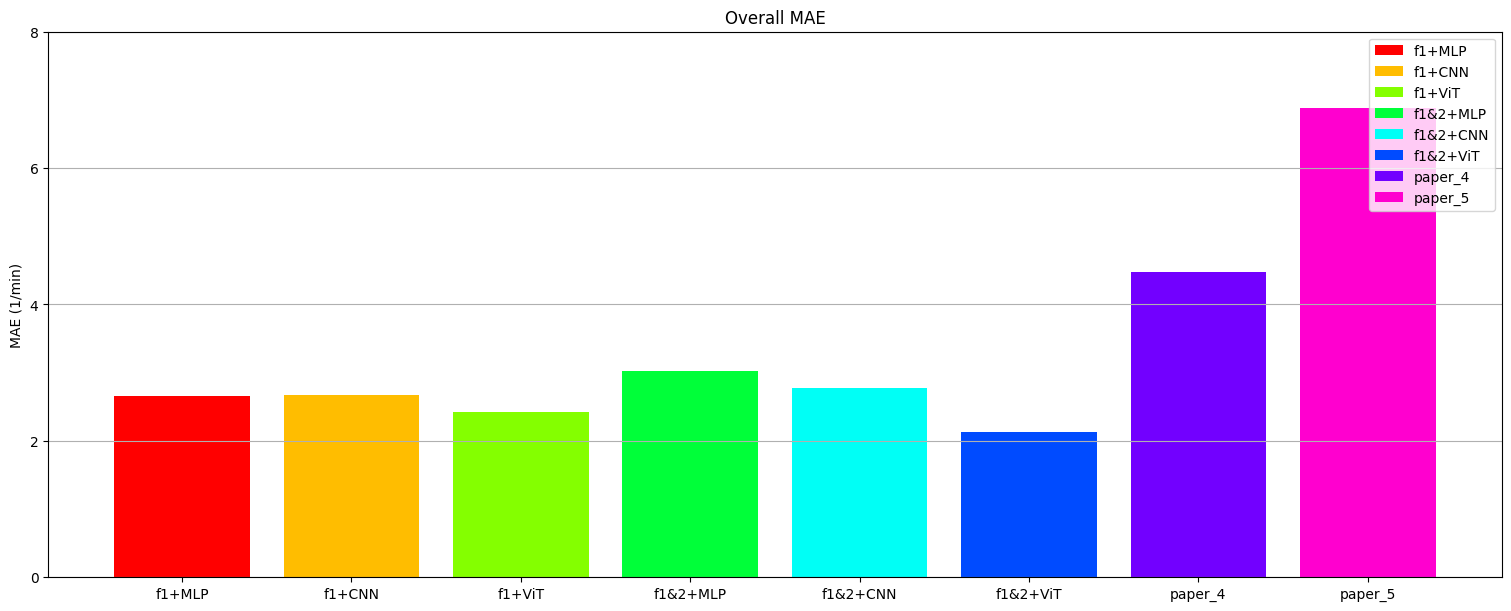

In [22]:
draw_overall_results(mae_test=[2.662, 2.667, 2.428, 3.024, 2.781, 2.137, 4.4778, 6.888],
                     models_name=['f1+MLP', 'f1+CNN', 'f1+ViT', 'f1&2+MLP', 'f1&2+CNN', 'f1&2+ViT', 'paper_4', 'paper_5'])

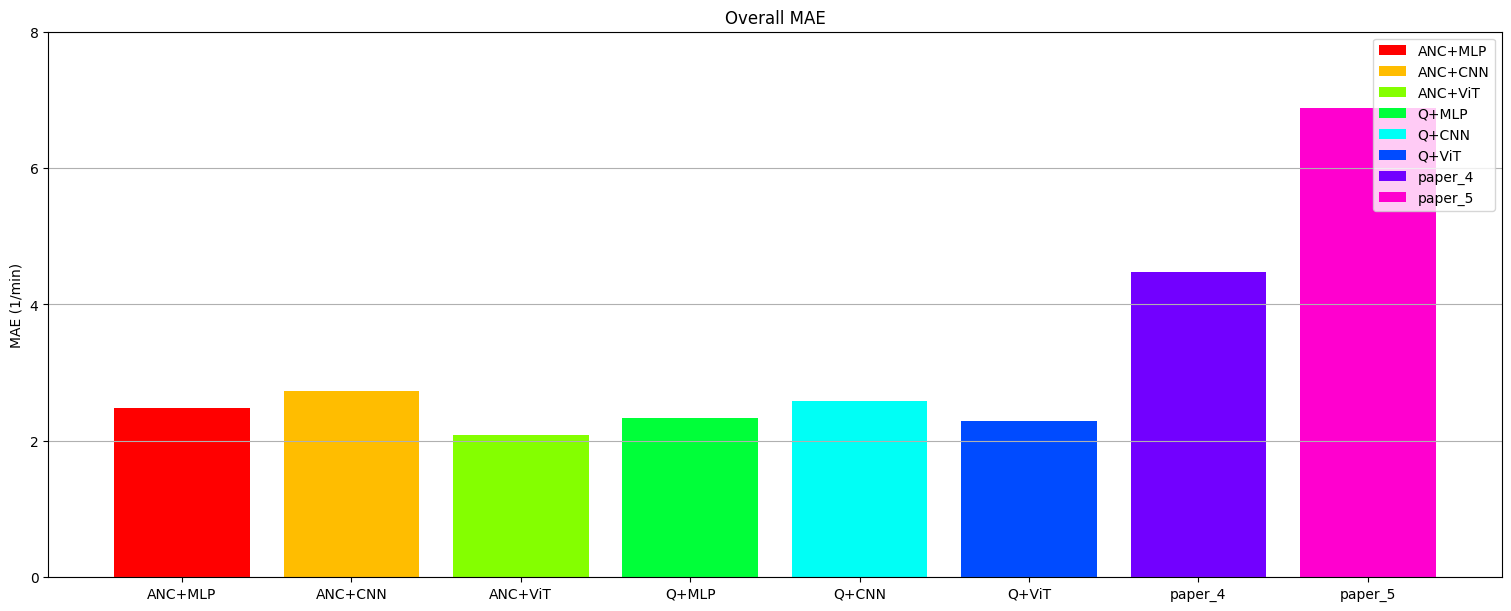

In [ ]:
draw_overall_results(mae_test=[2.485, 2.727, 2.085, 2.336, 2.589, 2.290, 4.4778, 6.888],
                     models_name=['ANC+MLP', 'ANC+CNN', 'ANC+ViT', 'Q+MLP', 'Q+CNN', 'Q+ViT', 'paper_4', 'paper_5'])

./data/10P/test\run_0514_1048.csv
paper_4 - MSE Loss: 89.5527, L1 Loss: 9.4632 1/min, R²:nan
paper_5 - MSE Loss: 172.0291, L1 Loss: 13.1160 1/min, R²:nan
./data/10P/test\run_0520_0735.csv
paper_4 - MSE Loss: 66.1662, L1 Loss: 7.6376 1/min, R²:-8.0768
paper_5 - MSE Loss: 142.0633, L1 Loss: 11.5734 1/min, R²:-18.4886
./data/10P/test\run_0520_1036.csv
paper_4 - MSE Loss: 45.7668, L1 Loss: 6.0008 1/min, R²:-6.9500


c:\Users\user\anaconda3\envs\rr\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 300 is greater than input length  = 266, using nperseg = 266
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\user\anaconda3\envs\rr\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\user\anaconda3\envs\rr\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


paper_5 - MSE Loss: 83.0399, L1 Loss: 8.2882 1/min, R²:-13.4246
./data/10P/test\run_0604_0714.csv
paper_4 - MSE Loss: 49.6117, L1 Loss: 6.7998 1/min, R²:-529.9206
paper_5 - MSE Loss: 90.9054, L1 Loss: 9.0507 1/min, R²:-971.8262
./data/10P/test\run_0604_0733.csv
paper_4 - MSE Loss: 8.9528, L1 Loss: 2.9527 1/min, R²:-66.4782
paper_5 - MSE Loss: 67.8967, L1 Loss: 7.6246 1/min, R²:-510.7435
./data/10P/test\sit_0514_1030.csv
paper_4 - MSE Loss: 10.8855, L1 Loss: 3.1448 1/min, R²:-9.9159
paper_5 - MSE Loss: 0.9979, L1 Loss: 0.6702 1/min, R²:-0.0007
./data/10P/test\sit_0520_0719.csv
paper_4 - MSE Loss: 4.2330, L1 Loss: 1.5766 1/min, R²:-5.4163
paper_5 - MSE Loss: 3.4599, L1 Loss: 0.9976 1/min, R²:-4.2444
./data/10P/test\sit_0520_1022.csv
paper_4 - MSE Loss: 1.7616, L1 Loss: 0.9111 1/min, R²:-3.6303
paper_5 - MSE Loss: 100.8607, L1 Loss: 6.5507 1/min, R²:-264.1020
./data/10P/test\sit_0604_0658.csv
paper_4 - MSE Loss: 4.5597, L1 Loss: 1.9622 1/min, R²:-6.4128
paper_5 - MSE Loss: 4.2303, L1 Loss

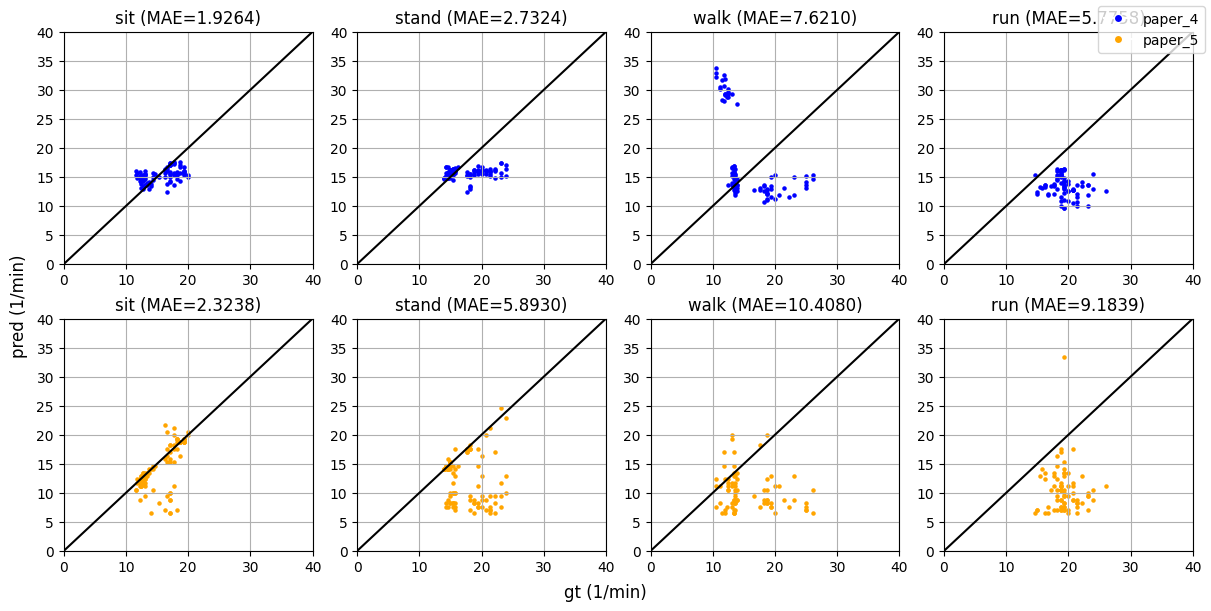

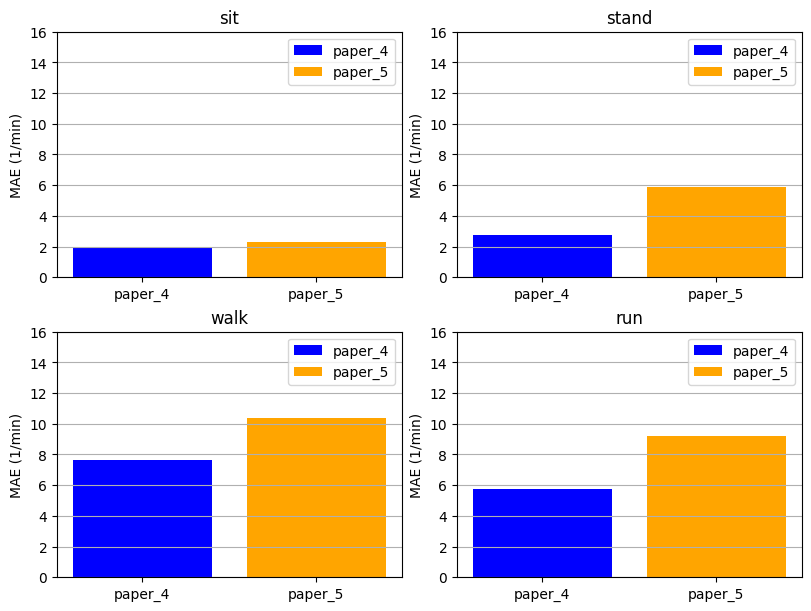

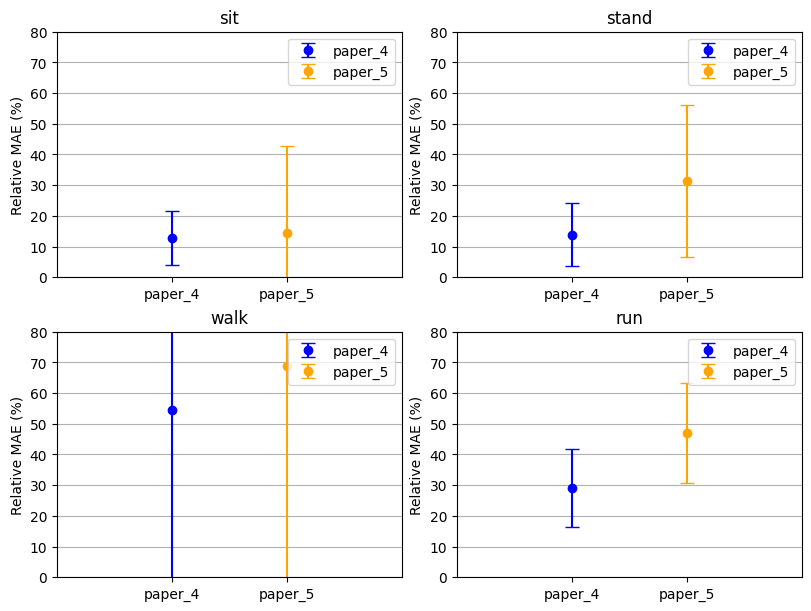

In [5]:
# parameters
window_size=256
stride=64
pad_mul=4
WIN_LEN=51
POLYORD=2
BPASS=2
MAX_VAL=0.48
THRESH_CONST=0.04

evaluate_paper_action("./data/10P/test",
                      visualize=True,
                      window_size=window_size,
                      stride=stride,
                      pad_mul=pad_mul,
                      WIN_LEN=WIN_LEN,
                      POLYORD=POLYORD,
                      BPASS=BPASS,
                      MAX_VAL=MAX_VAL,
                      THRESH_CONST=THRESH_CONST,)

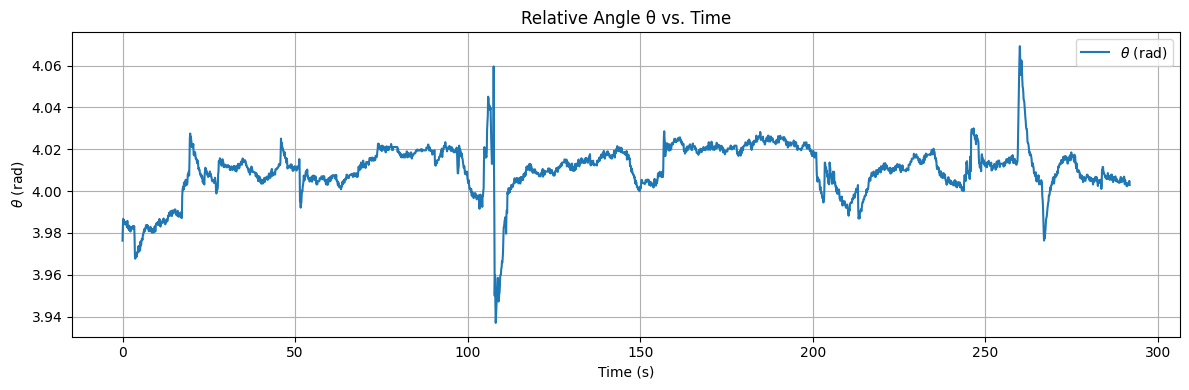

In [6]:
window_size=256
stride=64

target, ref = 'imu1', 'imu2'
Q_1 = data[[target + '_q_x', target + '_q_y', target + '_q_z', target + '_q_w']].to_numpy()
Q_2 = data[[ref + '_q_x', ref + '_q_y', ref + '_q_z', ref + '_q_w']].to_numpy()

theta_ls = calculate_theta(Q_1, Q_2)
t = np.linspace(0, len(theta_ls) / fs, len(theta_ls))

# Plot theta vs. time
plt.figure(figsize=(12, 4))
plt.plot(t, theta_ls, label=r'$\theta$ (rad)')
plt.xlabel('Time (s)')
plt.ylabel(r'$\theta$ (rad)')
plt.title('Relative Angle θ vs. Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

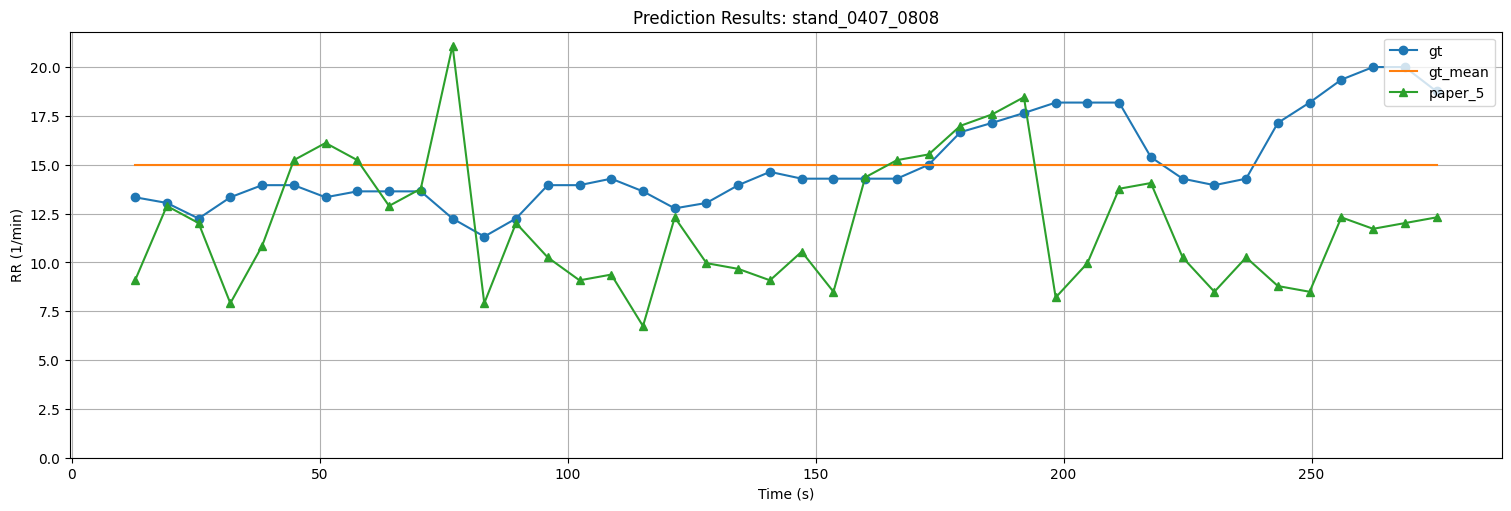

paper_5 - MSE Loss: 24.1739, L1 Loss: 3.9017 1/min, R²:-3.6651


In [7]:
# parameters
window_size=256
stride=64
pad_mul=8

target, ref = 'imu1', 'imu2'
Q_1 = data[[target + '_q_x', target + '_q_y', target + '_q_z', target + '_q_w']].to_numpy()
Q_2 = data[[ref + '_q_x', ref + '_q_y', ref + '_q_z', ref + '_q_w']].to_numpy()
force = data["Force"].to_numpy()

pred, gt, times = evaluate_paper_file_5(Q_1, Q_2, force, window_size=window_size, stride=stride, pad_mul=pad_mul, action_name=action_name)

In [8]:
q1 = np.array([[0, 0, 0, 1]]) # euler:(0, 0, 0)
q2 = np.array([[0.0000, 0.7071, 0.0000, 0.7071]]) # euler:(0, 90, 0)
q3 = np.array([[-0.5000, 0.5000, 0.5000, 0.5000]]) # euler:(0, 90, 90)
q4 = np.array([[0.7071, 0.0000, -0.7071, 0.0000]]) # euler:(180, 90, 0)

print(calculate_theta(q1, q2) * 180 / np.pi)
print(calculate_theta(q2, q3) * 180 / np.pi)
print(calculate_theta(q2, q4) * 180 / np.pi)

[89.99890105]
[90.00109893]
[180.]


# Paper 3, 4

In [9]:
@dataclass
class Result:
    abdomen_estimate: np.ndarray
    abdomen_signal: np.ndarray
    abdomen_pmaxima: np.ndarray
    abdomen_pminima: np.ndarray
    abdomen_rr_whole: np.ndarray
    abdomen_fpeak: float
    timestamp: np.ndarray


class RespAnalyzer:
    def __init__(
        self, win_len=51, polyord=2, bpass=2, max_val=0.48, fs=10, thresh_const=0.04
    ):
        self.win_len = win_len
        self.polyord = polyord
        self.bpass = bpass
        self.max_val = max_val
        self.fs = fs
        self.thresh_const = thresh_const

    @staticmethod
    def quaternion_product(q: np.ndarray, r: np.ndarray) -> np.ndarray:
        a1, b1, c1, d1 = q
        a2, b2, c2, d2 = r

        w = a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2
        x = a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2
        y = a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2
        z = a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2

        return np.array([w, x, y, z])

    def baseline_avg(self, q: np.ndarray, win_size: int = 97) -> np.ndarray:
        baseline_quats = np.zeros_like(q)

        for i in range(q.shape[1]):
            avg = np.convolve(q[:, i], np.ones(win_size) / win_size, mode="same")
            baseline_quats[:, i] = q[:, i] - avg

        return baseline_quats

    def get_thresh(self, q: np.ndarray) -> Tuple[np.ndarray, float]:
        pca = PCA(n_components=1)  # get the first component with maximum variance
        pca_signal = pca.fit_transform(q)[:, 0]  # primary component

        filtered_signal = savgol_filter(
            pca_signal, window_length=self.win_len, polyorder=self.polyord
        )
        peaks = ampd.find_peaks(filtered_signal)
        if len(peaks) > 1:
            peak_distances = np.diff(peaks)
            inverse_distances = 1 / peak_distances  # distances to frequency

            fmean = np.mean(inverse_distances)
            fstd = np.std(inverse_distances)
        else:
            print("Warn: no peaks here")
            fmean, fstd = 0.0, 0.0

        fLow = fmean - fstd if fmean > 0 else 0

        return filtered_signal, fLow

    def psd_max(
        self, data: np.ndarray, min_val: float, max_val: float
    ) -> Optional[float]:
        freq, psd = welch(data, fs=self.fs, window="hamming", noverlap=50, nperseg=300)

        valid_freq = np.where((freq >= min_val) & (freq <= max_val))[0]
        if not valid_freq.size:
            return None

        fpeak_idx = valid_freq[np.argmax(psd[valid_freq])]
        fpeak = freq[fpeak_idx]  # get the peak freq

        return fpeak

    def signal_max_min(
        self, signal: np.ndarray, fpeak: float
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        
        f_U = fpeak + self.thresh_const
        f_L = max(0.05, fpeak - self.thresh_const)

        b, a = butter(self.bpass, [f_L, f_U], btype="band")
        bandpass_filtered = filtfilt(b, a, signal)

        savgoled = savgol_filter(
            bandpass_filtered, window_length=self.win_len, polyorder=self.polyord
        )

        maxima = ampd.find_peaks(savgoled)
        minima = ampd.find_peaks(-savgoled)

        return savgoled, maxima, minima

    def metrics(
        self, min_indices: int, max_indices: np.ndarray, file_len: int
    ) -> Tuple[np.ndarray, np.ndarray]:
        resp_rates = []
        rr_whole = []

        for i in range(len(min_indices) - 1):
            cycle_maxima = max_indices[
                (max_indices > min_indices[i]) & (max_indices < min_indices[i + 1])
            ]

            if len(cycle_maxima) == 1:  # Valid breath cycle with one peak
                max_idx = cycle_maxima[0]

                inhale_time = (max_idx - min_indices[i]) / self.fs
                exhale_time = (min_indices[i + 1] - max_idx) / self.fs
                total_time = inhale_time + exhale_time
                resp_rate = 60 / total_time  # breaths per minute

                resp_rates.append(resp_rate)
                
            delta_t = (min_indices[i + 1] - min_indices[i]) / self.fs
            rr_pred = 60 / delta_t
            rr_range = min_indices[i + 1] - min_indices[i]
            
            # rr_whole is empty
            if not rr_whole:
                rr_whole.extend([rr_pred] * min_indices[i])
                rr_whole.extend([rr_pred] * rr_range)
            else:
                rr_whole.extend([rr_pred] * rr_range)

        if len(rr_whole) < file_len:
            rr_whole.extend([rr_pred] * (file_len-len(rr_whole)))

        return np.array(resp_rates), np.array(rr_whole)
        
    def visualize(
        self,
        idx: np.ndarray,
        signal: np.ndarray,
        min_indices: np.ndarray,
        max_indices: np.ndarray,
        gt_force: np.ndarray,
        title: str = "Breathing Cycles",
    ) -> plt.Figure:

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

        ax1.plot(idx, signal, "b-", label="Filtered Signal", linewidth=1.5)

        # peaks
        valid_min = min_indices[(min_indices >= 0) & (min_indices < len(signal))]
        ax1.scatter(
            idx[valid_min],
            signal[valid_min],
            color="red",
            marker="x",
            s=100,
            label="Minima",
        )
        valid_max = (
            max_indices[(max_indices >= 0) & (max_indices < len(signal))]
        )
        ax1.scatter(
            idx[valid_max],
            signal[valid_max],
            color="green",
            marker="o",
            s=100,
            label="Maxima",
        )

        ax1.set_xlabel("Timestamp")
        ax1.set_ylabel("Amplitude")
        ax1.legend()
        ax1.set_title(title)
        ax1.grid(True, alpha=0.3)

        ax2.plot(idx, gt_force, "g-", label="Respiration Effort")
        ax2.set_ylabel("Respiration Effort")
        ax2.tick_params(axis="y")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        freq, psd = welch(
            signal, fs=self.fs, window="hamming", noverlap=50, nperseg=300
        )

        ax3.plot(freq, psd, "b-", linewidth=1.5, label="PSD")
        ax3.set_xlabel("Frequency (Hz)")
        ax3.set_ylabel("Power Spectral Density")
        ax3.grid(True, alpha=0.3)

        ax3.legend()
        ax3.set_xlim(0, 1)  # Focus on relevant frequency range

        plt.tight_layout()
        return fig

    def eval(self, data: pd.DataFrame) -> Result:
        q_ab = data[["imu1_q_x", "imu1_q_y", "imu1_q_z", "imu1_q_w"]].to_numpy()
        q_ref = data[["imu2_q_x", "imu2_q_y", "imu2_q_z", "imu2_q_w"]].to_numpy()

        # Get thorax quaternion wrt ref
        # q_ab_ref = quaternion_product(q_ab, q_ref.T)
        q_ab_ref = np.array([quaternion_multiply(q_ab[i], quaternion_inverse(q_ref[i])) for i in range(len(q_ab))])

        # Establish baseline by averaging quaternions
        # base_q_ab = self.baseline_avg(q_ab)
        base_q_ab = self.baseline_avg(q_ab_ref)

        # Find the best component and get a frequency estimate
        ab_filtered_signal, ab_fLow = self.get_thresh(base_q_ab)

        # print(f"ab_fLow:{ab_fLow}")
        # fLow = min(th_fLow, ab_fLow)
        fLow = ab_fLow

        # get the region of interest by removing peaks generated by movement
        ab_fpeak = self.psd_max(ab_filtered_signal, fLow, max_val=self.max_val)

        # Get the crest and trough of the signal
        ab_sig, ab_max, ab_min = self.signal_max_min(ab_filtered_signal, ab_fpeak)

        # Estimate RR
        abdomen_result, abdomen_rr_whole = self.metrics(ab_min, ab_max, len(q_ab))
        # print(f"len(q_ab):{len(q_ab)}")
        # print(f"len(abdomen_rr_whole):{len(abdomen_rr_whole)}")
        # print(abdomen_rr_whole[:100])

        return Result(
            abdomen_estimate=abdomen_result,
            abdomen_signal=ab_sig,
            abdomen_pmaxima=ab_max,
            abdomen_pminima=ab_min,
            abdomen_fpeak=ab_fpeak,
            abdomen_rr_whole=abdomen_rr_whole,
            timestamp=data.index,
        )

result.abdomen_estimate:[15.         13.04347826 12.76595745 20.         13.95348837  8.95522388
 13.95348837 13.33333333 12.5        13.63636364 14.28571429 15.
 13.95348837 12.        ]
result.abdomen_rr_whole:(668,)
test\run_0514_1048
Abdomen estimate: 13.74, GT: 17.47
-----------
abdomen_pminima: (15,)
abdomen_estimate: (14,)


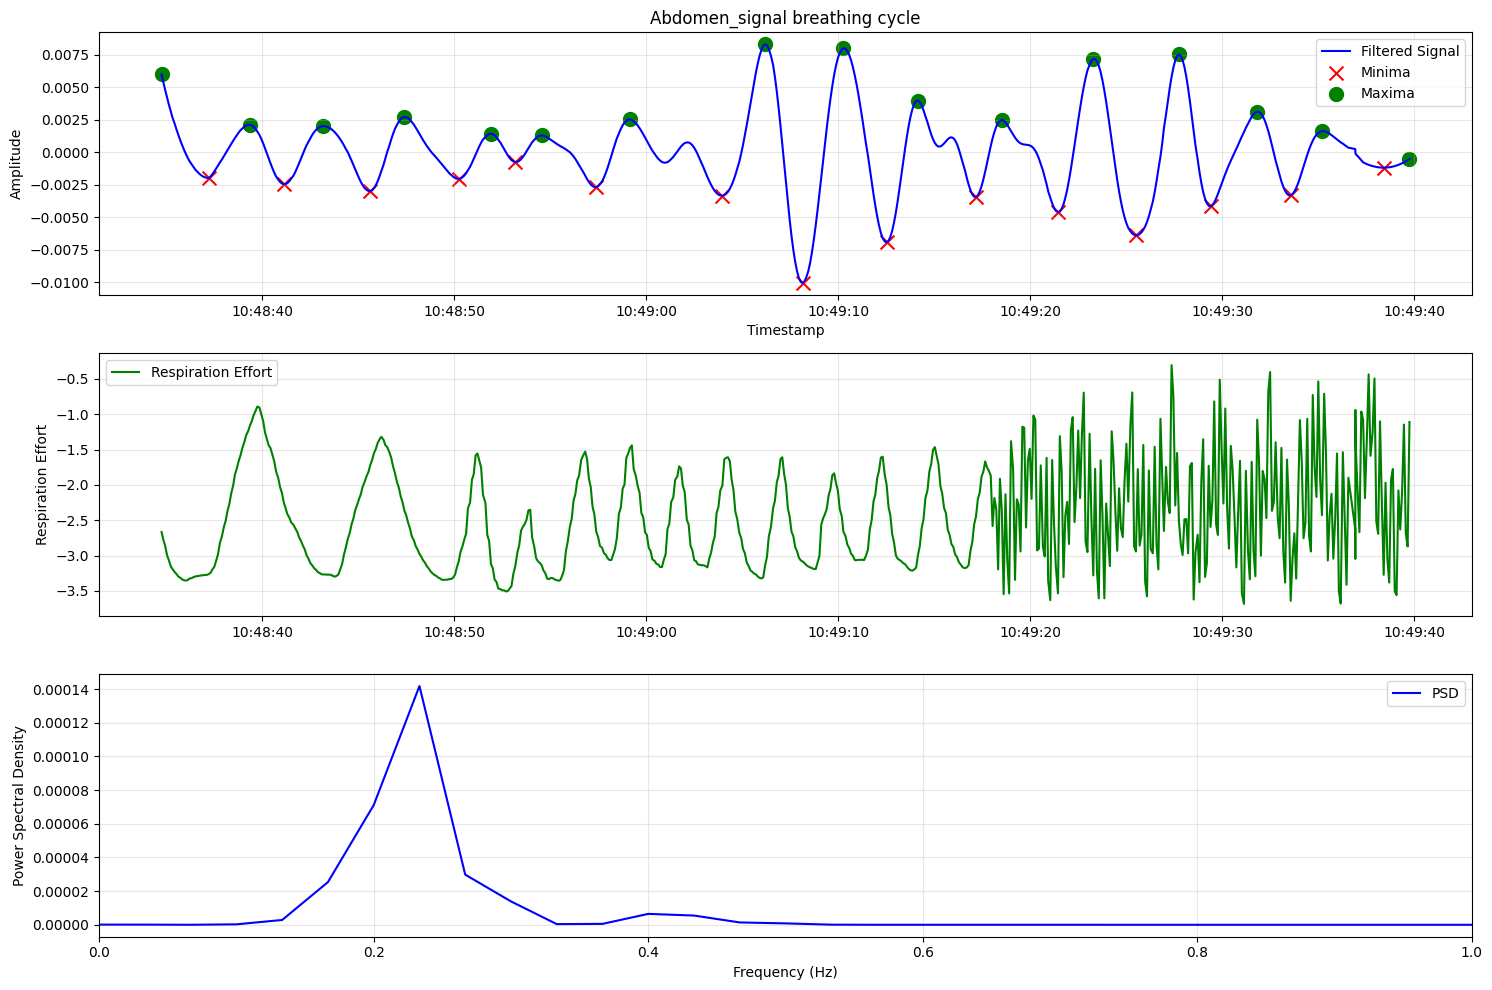

In [10]:
WIN_LEN = 51
POLYORD = 2
BPASS = 2
MAX_VAL = 0.48
FS = 10
THRESH_CONST = 0.04

for file in sorted(glob("data/8P/test/*.csv")):
    fname = file.split("/")[-1].split(".")[0]

    data = pd.read_csv(file, header=0)
    data["Timestamp"] = pd.to_datetime(data["Timestamp"])
    data = data.set_index("Timestamp")

    gt = data["RR"].replace(0.0, None).dropna().values

    analyzer = RespAnalyzer(
        win_len=WIN_LEN,
        polyord=POLYORD,
        bpass=BPASS,
        max_val=MAX_VAL,
        fs=FS,
        thresh_const=THRESH_CONST,
    )

    result = analyzer.eval(data)

    print(f"result.abdomen_estimate:{result.abdomen_estimate}")
    print(f"result.abdomen_rr_whole:{result.abdomen_rr_whole.shape}")

    ab_val = np.mean(result.abdomen_estimate)
    ab_err = ab_val - gt
    
    print(fname)
    print(f"Abdomen estimate: {ab_val:.2f}, GT: {np.mean(gt):.2f}")
    print("-----------")
        

    analyzer.visualize(
        data.index,
        result.abdomen_signal,
        result.abdomen_pminima,
        result.abdomen_pmaxima,
        data["Force"],
        title="Abdomen_signal breathing cycle",
    )

    print(f"abdomen_pminima: {result.abdomen_pminima.shape}")
    print(f"abdomen_estimate: {result.abdomen_estimate.shape}")

    # plt.savefig(f"data/plots/th_{fname}.png")
    plt.show()
    # plt.close()
    break